In [16]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import *
from keras.utils import Sequence
from keras.optimizers import Adam
import tensorflow.keras.backend as K
from numpy.random import seed

from utils import *
from model import *

# Define paths for figures and models
fig_path = "./figs/FORGE/"
model_path = "./model/"

# Create directories if they do not exist
os.makedirs(fig_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

Data shape (original): (960, 2000)


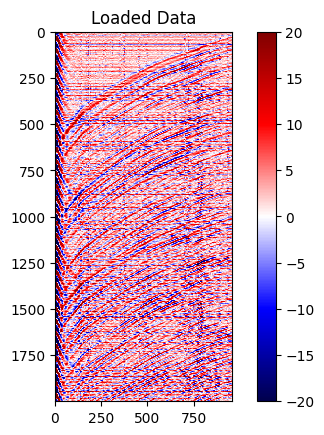

Data shape after patching: (51967, 576)
Data shape after patch selection: (41573, 576)


In [17]:
# Define paths and settings
data_path = './data/'
eq_num = 36
data_name = f'eq-{eq_num}'

# Data and patch parameters
w1, w2 = 24, 24  # Patch dimensions
z1, z2 = 6, 6    # Patch strides
batch = 1024     # Batch size
drop_rate = 0.2  # Drop rate for patch selection

# Load data
data = np.load(f'{data_path}{data_name}.npy')
print(f"Data shape (original): {data.shape}")

# Transpose and visualize data
data = data.T
plt.imshow(data, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()

# 2D patching
data_noise = yc_patch(data, w1, w2, z1, z2)

# Patch selection based on kurtosis
data_noise_selected = remove_columns_kurtosis(data_noise, drop_rate)
print(f"Data shape after patching: {data_noise.shape}")
print(f"Data shape after patch selection: {data_noise_selected.shape}")

In [18]:
class DebugLayer(tf.keras.layers.Layer):
    def __init__(self, label, **kwargs):
        super().__init__(**kwargs)
        self.label = label
    
    def call(self, inputs):
        tf.print(self.label, inputs, summarize=-1)
        return inputs  # Pass it through unchanged

In [19]:
# Define model parameters
D1 = 128
D2 = D1 // 4  # 32
D3 = D2 // 4  # 8
D4 = D3 // 2  # 2
print(f"Model parameters: D1={D1}, D2={D2}, D3={D3}, D4={D4}")

kernel_size = 3

# Define input sizes
INPUT_SIZE1 = data_noise.shape[0]
INPUT_SIZE2 = data_noise.shape[1]

# Model Input
input_img = Input(shape=(INPUT_SIZE2,))
input_img_expanded = input_img[:, tf.newaxis]

# Encoder
# Level 1
encoded1 = Dense(D1)(input_img_expanded)
encoded1 = BatchNormalization()(encoded1)
encoded1 = PReLU()(encoded1)

encoded1x = Dense(D1)(input_img_expanded)
encoded1x = PReLU()(encoded1x)
encoded1x = concatenate([encoded1x, encoded1], axis=-1)
encoded1x = Dense(D1)(encoded1x)
encoded1x = PReLU()(encoded1x)

skip1 = eca_block(encoded1x)

# Level 2
encoded2 = Dense(D2)(encoded1x)
encoded2 = BatchNormalization()(encoded2)
encoded2 = PReLU()(encoded2)

encoded2x = Dense(D2)(encoded1x)
encoded2x = PReLU()(encoded2x)
encoded2x = concatenate([encoded2x, encoded2], axis=-1)
encoded2x = Dense(D2)(encoded2x)
encoded2x = PReLU()(encoded2x)

skip2 = eca_block(encoded2x)

# # Level 3
# encoded2x = DebugLayer('10')(encoded2x)
# encoded3 = Conv1D(filters=D3, kernel_size=kernel_size, padding='same', name='e3')(encoded2x)
# encoded3 = DebugLayer('11')(encoded3)
# # encoded3 = BatchNormalization()(encoded3)
# encoded3 = DebugLayer('12')(encoded3)
# encoded3 = PReLU()(encoded3)
# encoded3 = DebugLayer('13')(encoded3)

# encoded2x = DebugLayer('1')(encoded2x)
# encoded3x = Conv1D(filters=D3, kernel_size=kernel_size + 3, padding='same', name='e33')(encoded2x)
# encoded3x = DebugLayer('2')(encoded3x)
# encoded3x = PReLU()(encoded3x)
# encoded3x = DebugLayer('3')(encoded3x)
# encoded3x = concatenate([encoded3x, encoded3], axis=-1)
# encoded3x = DebugLayer('4')(encoded3x)
# encoded3x = Dense(D3)(encoded3x)
# encoded3x = DebugLayer('5')(encoded3x)
# encoded3x = PReLU()(encoded3x)
# encoded3x = DebugLayer('6')(encoded3x)

# Level 3
encoded3 = Dense(D3)(encoded2x)
encoded3 = BatchNormalization()(encoded3)
encoded3 = PReLU()(encoded3)
encoded3x = Dense(D3)(encoded2x)
encoded3x = PReLU()(encoded3x)
encoded3x = concatenate([encoded3x, encoded3], axis=-1)
encoded3x = Dense(D3)(encoded3x)
encoded3x = PReLU()(encoded3x)

skip3 = eca_block(encoded3x)

# Decoder
# Level 3
decoded3 = Dense(D3)(encoded3x)
decoded3 = BatchNormalization()(decoded3)
decoded3 = PReLU()(decoded3)

decoded3x = Dense(D3)(encoded3x)
decoded3x = PReLU()(decoded3x)
decoded3x = concatenate([decoded3x, decoded3], axis=-1)
decoded3x = Dense(D3)(decoded3x)
decoded3x = PReLU()(decoded3x)

decoded3_combined = concatenate([decoded3x, skip3])

# Level 2
decoded2 = Dense(D2)(decoded3_combined)
decoded2 = BatchNormalization()(decoded2)
decoded2 = PReLU()(decoded2)

decoded2x = Dense(D2)(decoded3_combined)
decoded2x = PReLU()(decoded2x)
decoded2x = concatenate([decoded2x, decoded2], axis=-1)
decoded2x = Dense(D2)(decoded2x)
decoded2x = PReLU()(decoded2x)

decoded2_combined = concatenate([decoded2x, skip2])

# Level 1
decoded1 = Dense(D1)(decoded2_combined)
decoded1 = BatchNormalization()(decoded1)
decoded1 = PReLU()(decoded1)

decoded1x = Dense(D1)(decoded2_combined)
decoded1x = PReLU()(decoded1x)
decoded1x = concatenate([decoded1x, decoded1], axis=-1)
decoded1x = Dense(D1)(decoded1x)
decoded1x = PReLU()(decoded1x)

decoded1_combined = concatenate([decoded1x, skip1])

# Output
final_decoded = Dense(INPUT_SIZE2 // 3)(decoded1_combined)
final_decoded = Dense(INPUT_SIZE2)(final_decoded)
final_decoded = Flatten()(final_decoded)

# Build the model
autoencoder = Model(inputs=input_img, outputs=final_decoded)

# Compile the model
optimizer = Adam(learning_rate=0.01)
autoencoder.compile(optimizer=optimizer, loss='MSE')

# Summary of the model
autoencoder.summary()

Model parameters: D1=128, D2=32, D3=8, D4=4
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 576)]                0         []                            
                                                                                                  
 tf.__operators__.getitem_2  (None, 1, 576)               0         ['input_3[0][0]']             
  (SlicingOpLambda)                                                                               
                                                                                                  
 dense_52 (Dense)            (None, 1, 128)               73856     ['tf.__operators__.getitem_2[0
                                                                    ][0]']                        
                                                

In [20]:
# autoencoder.train_on_batch(data_noise_selected[:2], data_noise_selected[:2])

In [21]:
# Training Parameters
epochs = 50
batch_size = 1024

# Early stopping and model checkpoint callbacks
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(
    # filepath=f'{model_path}/x/FORGE_model_{data_name}_p{w1}_s{z1}_drop_{drop_rate}_ep{epochs}' + '{epoch}.h5',
    filepath=f'{model_path}FORGE_model_{data_name}_p{w1}_s{z1}_drop_{drop_rate}_ep{epochs}x.h5',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Timing the training process
start_time = time.time()

# Model training
history = autoencoder.fit(
    data_noise_selected,
    data_noise_selected,
    epochs=1,
    batch_size=batch_size,
    shuffle=True,
    verbose=1,
    validation_split=0.1,
    callbacks=[es, mc]
)

# End timing and print training duration
end_time = time.time()
print(f"Training time for FORGE data: {end_time - start_time:.4f} seconds")

37/37 [==============================] - ETA: 0s - loss: 495.8970
Epoch 1: loss improved from inf to 495.89700, saving model to ./model\FORGE_model_eq-36_p24_s6_drop_0.2_ep50x.h5
37/37 [==============================] - 12s 72ms/step - loss: 495.8970 - val_loss: 441.3842
Training time for FORGE data: 11.7889 seconds


In [31]:
autoencoder.save(f'{model_path}AE.h5')

d:\Code\ML\Unsupervised-DAS-Denoising\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
from keras.models import load_model

model1 = load_model(f'{model_path}AE.h5')

data_noisy = yc_patch(data.T, w1, w2, z1, z2)

## prediction
out1 = model1.predict(data_noisy)
out1 = np.transpose(out1)


# unpatching
[n1, n2] = data.T.shape
predicted1 = yc_patch_inv(out1,n1,n2,w1,w2,z1,z2)

1624/1624 [==============================] - 6s 3ms/step


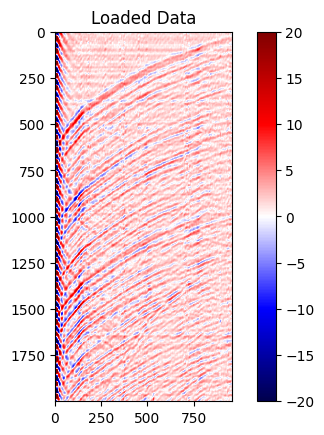

In [44]:
plt.imshow(predicted1.T, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()

In [ ]:
# prediction
out = autoencoder.predict(data_noise)
out = np.transpose(out)

# unpatching
[n1, n2] = data.shape
predicted = yc_patch_inv(out,n1,n2,w1,w2,z1,z2)

1624/1624 [==============================] - 5s 3ms/step


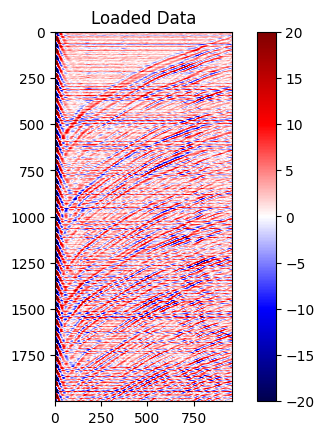

In [29]:
plt.imshow(predicted, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()


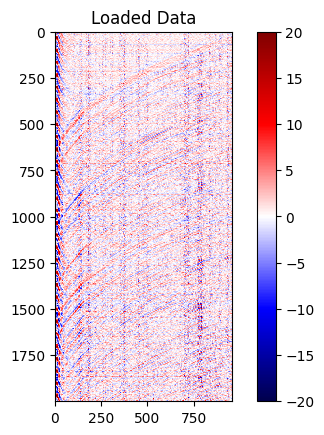

In [30]:
diff = data - predicted

plt.imshow(diff, cmap='seismic', vmin=-20, vmax=20)
plt.title('Loaded Data')
plt.colorbar()
plt.show()